# Step 3: Clustering of Charging Stations

## 3.1 Extract & Scale Geospatial Data

In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Extracting relevant columns for clustering
geo_data = df_processed[['latitude', 'longitude']].dropna()

# Standardizing the data using StandardScaler
scaler = StandardScaler()
geo_data_scaled = scaler.fit_transform(geo_data)


## 3.2 Find the Optimal Number of Clusters (K)

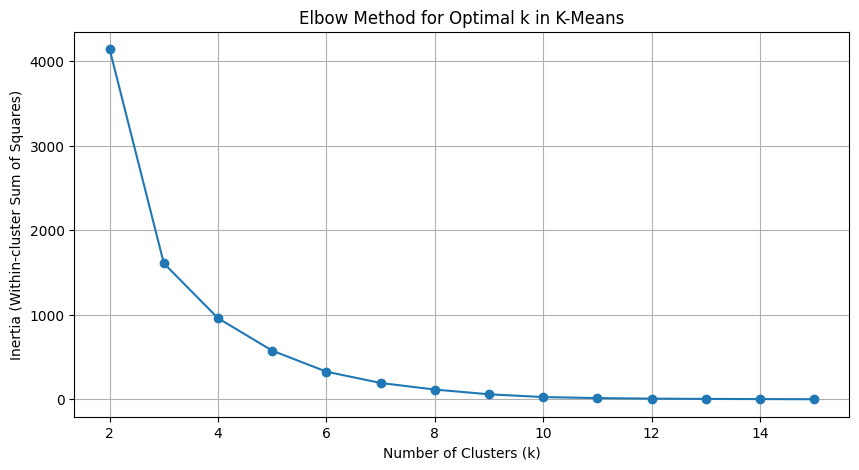

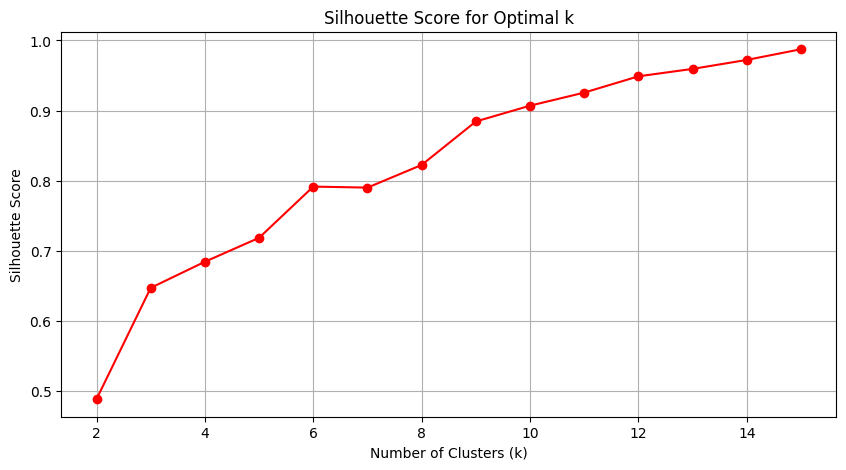

Optimal number of clusters: 15


In [ ]:
# Determining the optimal number of clusters
inertia = []
silhouette_scores = []
k_values = range(2, 16)  # Testing cluster values from 2 to 15

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(geo_data_scaled)
    inertia.append(kmeans.inertia_)

    # Calculating silhouette score (higher is better)
    silhouette_scores.append(silhouette_score(geo_data_scaled, kmeans.labels_))

# Plotting Elbow Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k in K-Means")
plt.grid(True)
plt.show()

# Plotting Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='r')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.grid(True)
plt.show()

# Determining optimal k (highest silhouette score)
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")


## 3.3 Apply K-Means Clustering

In [ ]:
# Applying K-Means Clustering using optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_processed['cluster'] = kmeans.fit_predict(geo_data_scaled)


## 3.4 Visualize Clusters

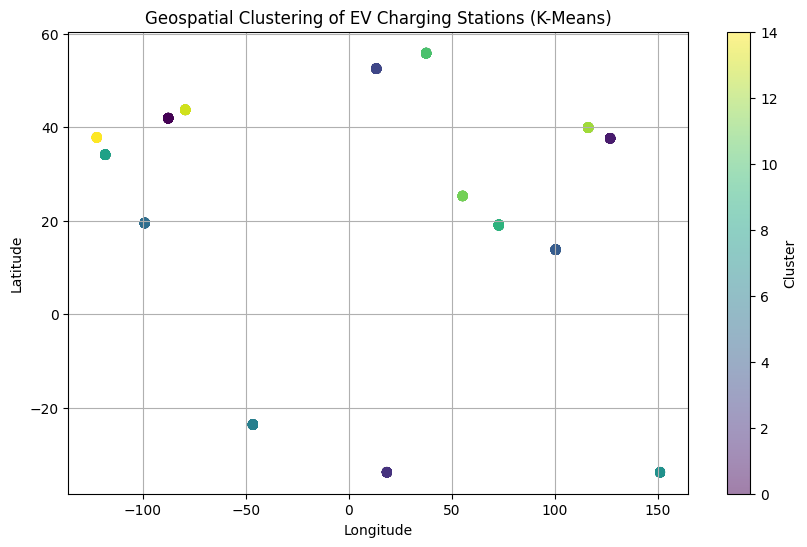

In [ ]:
# Plotting clustered charging stations
plt.figure(figsize=(10, 6))
plt.scatter(df_processed['longitude'], df_processed['latitude'], c=df_processed['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geospatial Clustering of EV Charging Stations (K-Means)")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


## 3.5 Assign City Names to Clusters & Save it

In [ ]:
# Finding the most frequent city in each cluster
cluster_city_mapping = df_processed.groupby('cluster')['city'].agg(lambda x: x.mode()[0])
print("\nCluster to City Mapping:")
print(cluster_city_mapping)

# Creating a new column with human-readable cluster names
df_processed['cluster_city_name'] = df_processed['cluster'].map(cluster_city_mapping)

# Saving dataset with named clusters
clustered_named_file_path = "/content/drive/MyDrive/clustered_ev_charging_stations_with_city_names.csv"
df_processed.to_csv(clustered_named_file_path, index=False)

# Displaying the cluster-wise station count with city names
cluster_counts = df_processed.groupby(['cluster', 'cluster_city_name']).size().reset_index(name='count')
print("\nCluster-wise station count with city names:")
print(cluster_counts)



Cluster to City Mapping:
cluster
0           Chicago
1             Seoul
2         Cape Town
3            Berlin
4           Bangkok
5       Mexico City
6         São Paulo
7            Sydney
8       Los Angeles
9            Mumbai
10           Moscow
11            Dubai
12          Beijing
13          Toronto
14    San Francisco
Name: city, dtype: object

Cluster-wise station count with city names:
    cluster cluster_city_name  count
0         0           Chicago    308
1         1             Seoul    299
2         2         Cape Town    208
3         3            Berlin    292
4         4           Bangkok    314
5         5       Mexico City    321
6         6         São Paulo    279
7         7            Sydney    140
8         8       Los Angeles    286
9         9            Mumbai    216
10       10            Moscow    281
11       11             Dubai    104
12       12           Beijing    319
13       13           Toronto    257
14       14     San Francisco    146


## 3.6 City-wise Cluster EDA

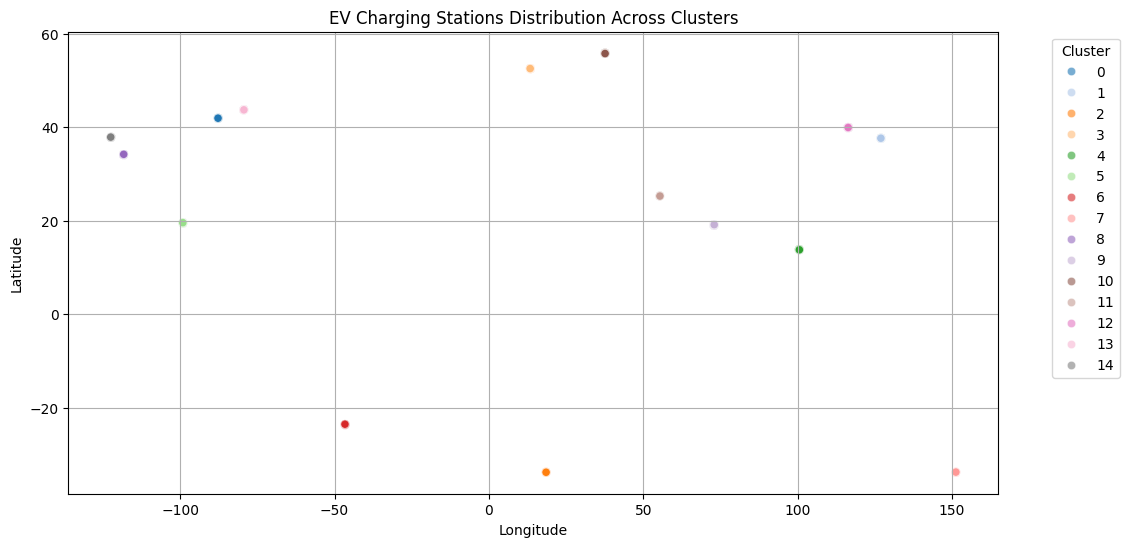

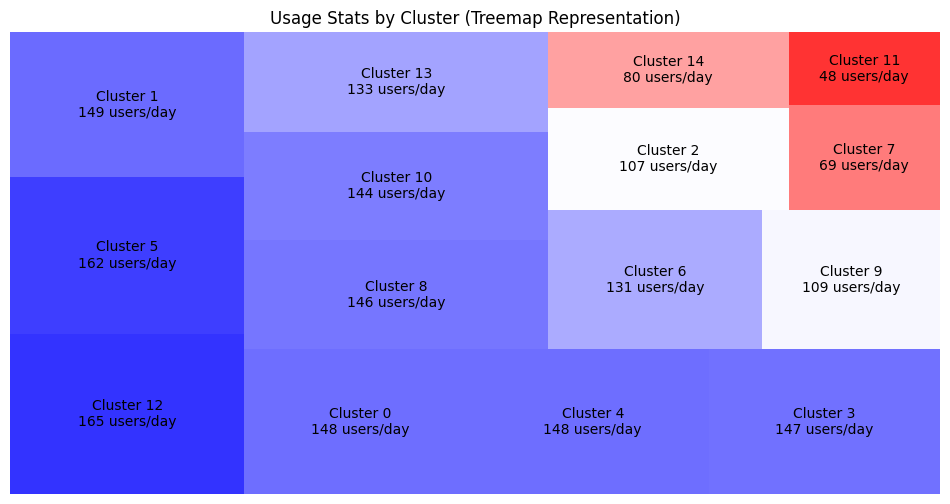


Total Users per Cluster (Sorted High to Low):
Cluster 12: 165 users/day
Cluster 5: 162 users/day
Cluster 1: 149 users/day
Cluster 0: 148 users/day
Cluster 4: 148 users/day
Cluster 3: 147 users/day
Cluster 8: 146 users/day
Cluster 10: 144 users/day
Cluster 13: 133 users/day
Cluster 6: 131 users/day
Cluster 9: 109 users/day
Cluster 2: 107 users/day
Cluster 14: 80 users/day
Cluster 7: 69 users/day
Cluster 11: 48 users/day


<ipython-input-22-634e20e92566>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cluster_column, y='usage_stats_avg_users_per_day', palette='coolwarm_r', order=clusters)


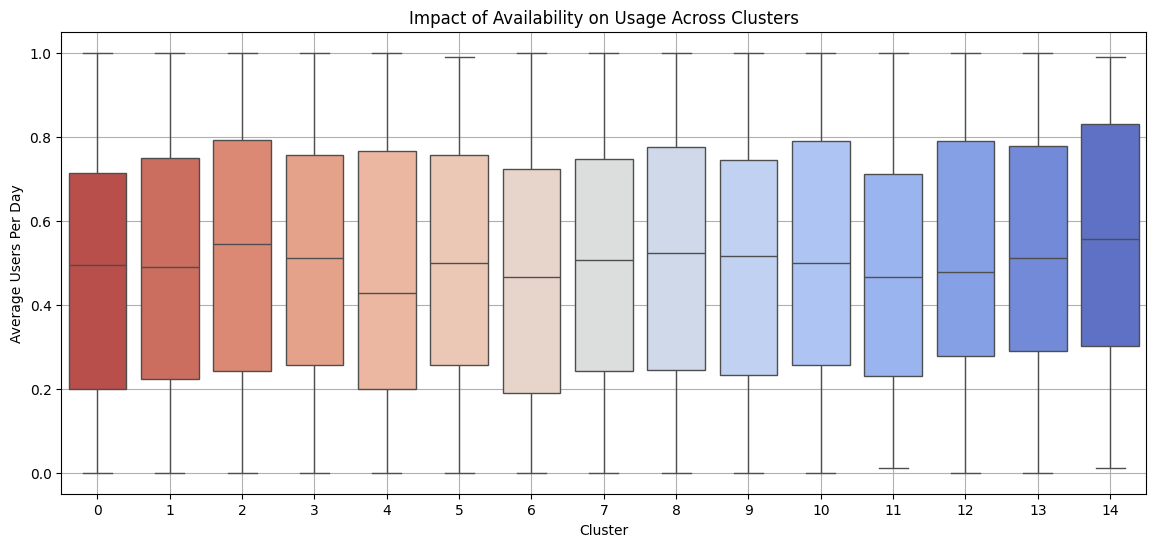

<ipython-input-22-634e20e92566>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=cluster_column, y='usage_stats_avg_users_per_day', palette='coolwarm_r', order=clusters, inner='quartile')


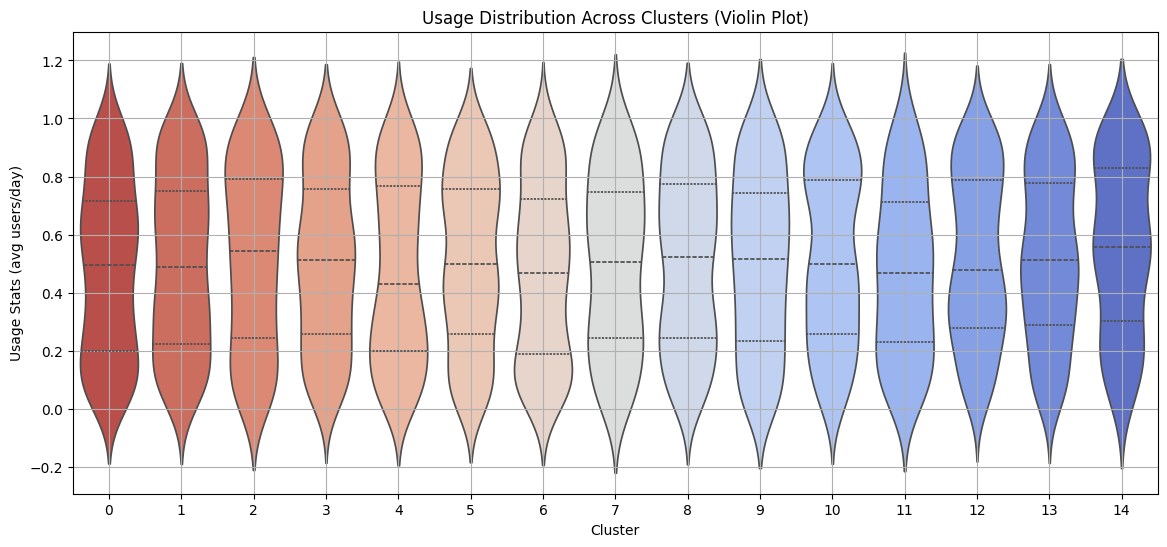

In [ ]:
!pip install squarify
import squarify  # For treemap visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# Defining a fxn that generates EDA plots for city clusters after clustering is done.
def perform_eda_city_clusters(df, cluster_column='cluster'):
    # Sort clusters in ascending order
    df = df.sort_values(by=[cluster_column])
    clusters = sorted(df[cluster_column].unique())

    # 1. Scattterplot for Charging Station Distribution
    plt.figure(figsize=(12, 6))
    scatter = sns.scatterplot(data=df, x='longitude', y='latitude', hue=cluster_column, palette='tab20', alpha=0.6)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("EV Charging Stations Distribution Across Clusters")

    # Ensuring all clusters appear in the legend
    handles, labels = scatter.get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))  # Remove duplicates
    scatter.legend(handles=handles[:len(unique_labels)], title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.show()

    # 2. Treemap for Usage Stats Treemap (Gradient Color: Red → White → Blue)
    cluster_usage = df.groupby(cluster_column)['usage_stats_avg_users_per_day'].sum().sort_values(ascending=False)

    # Generating a color gradient from Red (low) → White (mid) → Blue (high)
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["red", "white", "blue"])
    norm = plt.Normalize(min(cluster_usage), max(cluster_usage))
    colors = [cmap(norm(value)) for value in cluster_usage]

    # Creating the treemap
    plt.figure(figsize=(12, 6))
    squarify.plot(
        sizes=cluster_usage,
        label=[f"Cluster {i}\n{int(v)} users/day" for i, v in cluster_usage.items()],
        alpha=0.8,
        color=colors
    )
    plt.title("Usage Stats by Cluster (Treemap Representation)")
    plt.axis('off')
    plt.show()

    # Printing cluster User Stats for Clarity
    print("\nTotal Users per Cluster (Sorted High to Low):")
    for cluster, usage in cluster_usage.items():
        print(f"Cluster {cluster}: {int(usage)} users/day")

    # 3. Boxplot of all clusters showiing Availability vs. Usage Stats
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df, x=cluster_column, y='usage_stats_avg_users_per_day', palette='coolwarm_r', order=clusters)
    plt.xlabel("Cluster")
    plt.ylabel("Average Users Per Day")
    plt.title("Impact of Availability on Usage Across Clusters")
    plt.grid(True)
    plt.show()

    # 4. Violin plot for Improved Distribution of Charging Station Utilization
    plt.figure(figsize=(14, 6))
    sns.violinplot(data=df, x=cluster_column, y='usage_stats_avg_users_per_day', palette='coolwarm_r', order=clusters, inner='quartile')
    plt.xlabel("Cluster")
    plt.ylabel("Usage Stats (avg users/day)")
    plt.title("Usage Distribution Across Clusters (Violin Plot)")
    plt.grid(True)
    plt.show()

# Displating
perform_eda_city_clusters(df_processed, cluster_column='cluster')
